In [16]:
!wget -O sample.jpg "https://raw.githubusercontent.com/justin-2003/CSC467_Module4Assignment/main/prokudin-gorskii/prokudin-gorskii/00125v.jpg"
!wget -O seoul_tableau.jpg "https://raw.githubusercontent.com/justin-2003/CSC467_Module4Assignment/main/seoul_tableau.jpg"
!wget -O vancouver_tableau.jpg "https://raw.githubusercontent.com/justin-2003/CSC467_Module4Assignment/main/vancouver_tableau.jpg"


--2025-04-01 17:13:59--  https://raw.githubusercontent.com/justin-2003/CSC467_Module4Assignment/main/prokudin-gorskii/prokudin-gorskii/00125v.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55764 (54K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  54.46K  --.-KB/s    in 0.001s  

2025-04-01 17:13:59 (39.7 MB/s) - ‘sample.jpg’ saved [55764/55764]

--2025-04-01 17:13:59--  https://raw.githubusercontent.com/justin-2003/CSC467_Module4Assignment/main/seoul_tableau.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting res

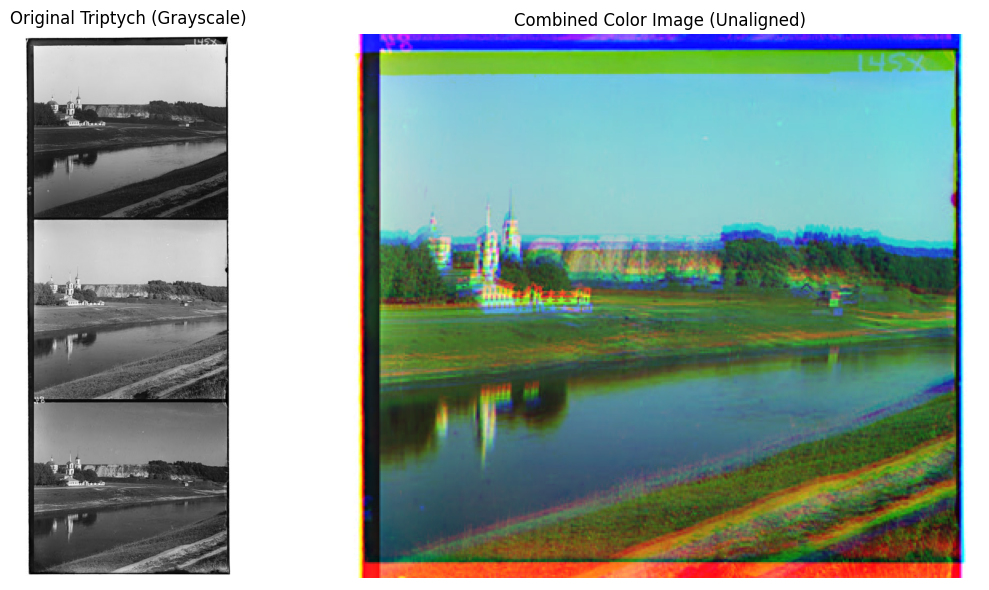

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os

def split_triptych(triptych):

    # Calculate the height of each panel
    height = triptych.shape[0]
    panel_height = height // 3

    # Extract each channel (B, G, R from top to bottom)
    blue = triptych[:panel_height, :]
    green = triptych[panel_height:2*panel_height, :]
    red = triptych[2*panel_height:3*panel_height, :]

    # Stack them in R, G, B order to create a color image
    color_image = np.stack([red, green, blue], axis=-1)

    return color_image

# Load an example image (replace with your actual image path)
image_path = 'sample.jpg'
triptych = plt.imread(image_path)

# Process the image
color_image = split_triptych(triptych)

# Save the result
output_path = 'emir_color_unaligned.jpg'
plt.imsave(output_path, color_image)

# Display the original and combined images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(triptych, cmap='gray')
plt.title('Original Triptych (Grayscale)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(color_image)
plt.title('Combined Color Image (Unaligned)')
plt.axis('off')

plt.tight_layout()
plt.show()

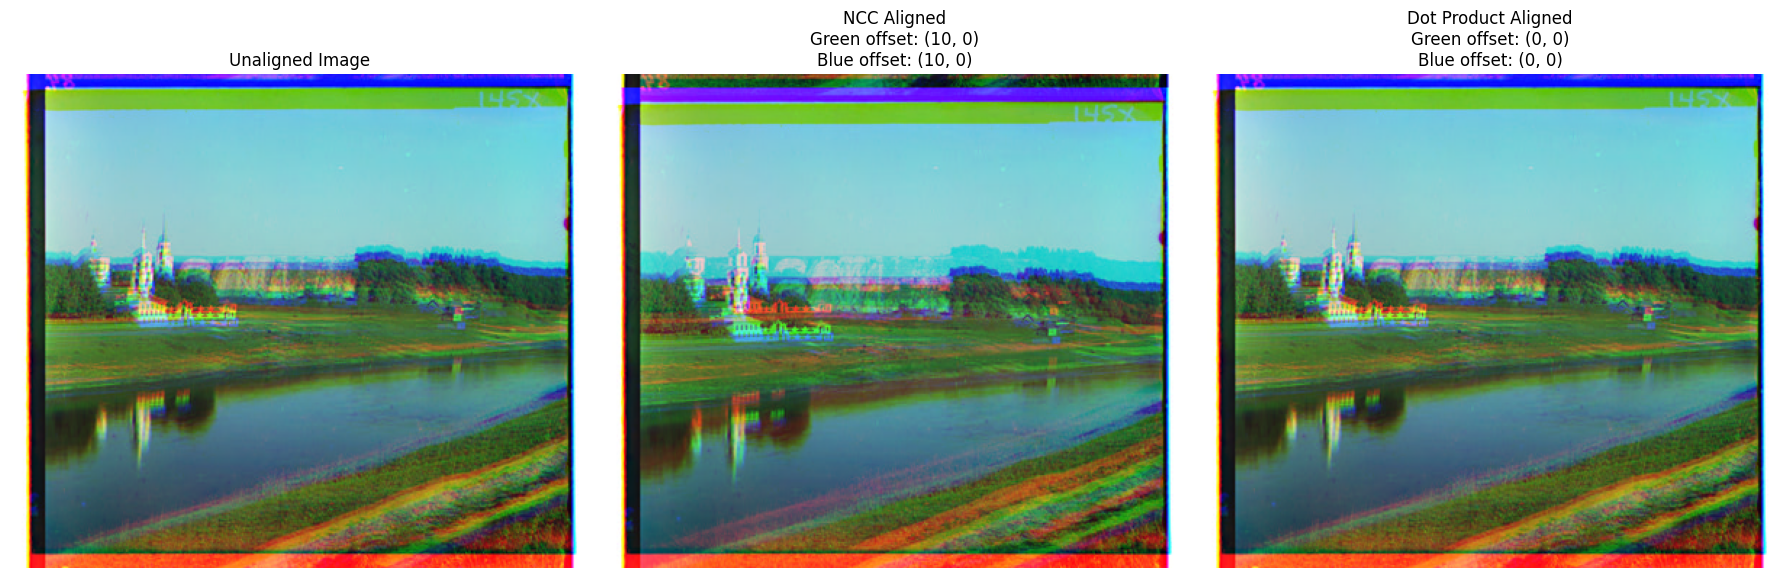

In [22]:
def normalized_cross_correlation(channel1, channel2):

    # Normalize the channels
    c1_norm = (channel1 - np.mean(channel1)) / np.std(channel1)
    c2_norm = (channel2 - np.mean(channel2)) / np.std(channel2)

    # Compute NCC
    return np.sum(c1_norm * c2_norm)

def simple_dot_product(channel1, channel2):

    return np.sum(channel1 * channel2)

def best_offset(ref_channel, mov_channel, search_range=15, metric='ncc'):

    best_score = -np.inf
    best_offset = (0, 0)

    for dy in range(-search_range, search_range + 1):
        for dx in range(-search_range, search_range + 1):
            # Shift the moving channel
            shifted = np.roll(mov_channel, (dy, dx), axis=(0, 1))

            # Compute valid region (avoid edge artifacts)
            h, w = ref_channel.shape
            valid_ref = ref_channel[max(0, -dy):h-max(0, dy), max(0, -dx):w-max(0, dx)]
            valid_shifted = shifted[max(0, dy):h-max(0, -dy), max(0, dx):w-max(0, -dx)]

            # Calculate similarity
            if metric == 'ncc':
                score = normalized_cross_correlation(valid_ref, valid_shifted)
            else:  # simple dot product
                score = simple_dot_product(valid_ref, valid_shifted)

            if score > best_score:
                best_score = score
                best_offset = (dy, dx)

    return best_offset, best_score

def align_and_combine(triptych, search_range=15, metric='ncc'):

    height = triptych.shape[0]
    panel_height = height // 3

    # Split channels (B, G, R from top to bottom)
    blue = triptych[:panel_height, :]
    green = triptych[panel_height:2*panel_height, :]
    red = triptych[2*panel_height:3*panel_height, :]

    # Align green to red
    (g_dy, g_dx), _ = best_offset(red, green, search_range, metric)
    aligned_green = np.roll(green, (g_dy, g_dx), axis=(0, 1))

    # Align blue to red
    (b_dy, b_dx), _ = best_offset(red, blue, search_range, metric)
    aligned_blue = np.roll(blue, (b_dy, b_dx), axis=(0, 1))

    # Combine into RGB image
    color_image = np.stack([red, aligned_green, aligned_blue], axis=-1)

    return color_image, {'green': (g_dy, g_dx), 'blue': (b_dy, b_dx)}

# Process the sample image you downloaded
image_path = 'sample.jpg'
triptych = plt.imread(image_path)

# Align with NCC (better method)
aligned_ncc, offsets_ncc = align_and_combine(triptych, metric='ncc')

# Align with dot product (for comparison)
aligned_dot, offsets_dot = align_and_combine(triptych, metric='dot')

# Save and display results
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(split_triptych(triptych))
plt.title('Unaligned Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(aligned_ncc)
plt.title(f"NCC Aligned\nGreen offset: {offsets_ncc['green']}\nBlue offset: {offsets_ncc['blue']}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(aligned_dot)
plt.title(f"Dot Product Aligned\nGreen offset: {offsets_dot['green']}\nBlue offset: {offsets_dot['blue']}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Save aligned images
plt.imsave('00125v_aligned_ncc.jpg', aligned_ncc)
plt.imsave('00125v_aligned_dot.jpg', aligned_dot)


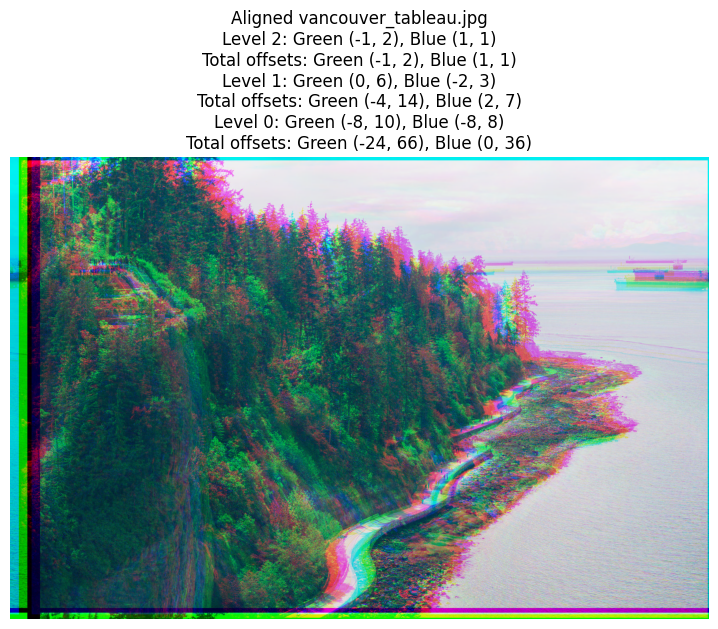

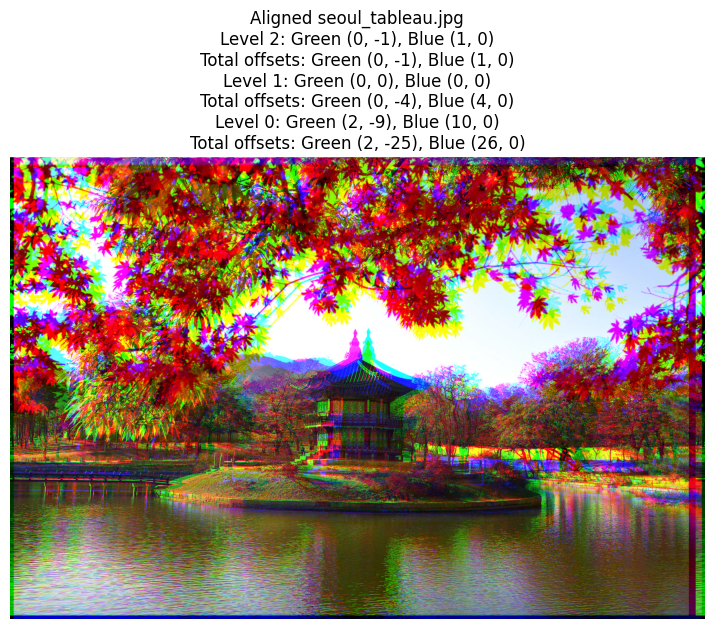

In [38]:
def pyramid_align(triptych, search_range=10, levels=3, metric='ncc'):
    height = triptych.shape[0]
    panel_height = height // 3

    # Split channels
    blue = triptych[:panel_height, :]
    green = triptych[panel_height:2*panel_height, :]
    red = triptych[2*panel_height:3*panel_height, :]

    # Initialize offsets
    g_dy, g_dx = 0, 0
    b_dy, b_dx = 0, 0

    all_offsets = []

    # Create pyramid from coarsest to finest level
    for level in range(levels-1, -1, -1):
        scale_factor = 4 ** level
        current_size = (red.shape[0] // scale_factor, red.shape[1] // scale_factor)

        # Resize images for this level
        red_resized = cv2.resize(red, (current_size[1], current_size[0]))
        green_resized = cv2.resize(np.roll(green, (g_dy, g_dx), axis=(0, 1)),
                                 (current_size[1], current_size[0]))
        blue_resized = cv2.resize(np.roll(blue, (b_dy, b_dx), axis=(0, 1)),
                                (current_size[1], current_size[0]))

        # Find offsets at this level
        (level_g_dy, level_g_dx), _ = best_offset(red_resized, green_resized, search_range, metric)
        (level_b_dy, level_b_dx), _ = best_offset(red_resized, blue_resized, search_range, metric)

        # Update total offsets (multiply by 4 for next level)
        g_dy = g_dy * 4 + level_g_dy
        g_dx = g_dx * 4 + level_g_dx
        b_dy = b_dy * 4 + level_b_dy
        b_dx = b_dx * 4 + level_b_dx

        all_offsets.append({
            'level': level,
            'green': (level_g_dy, level_g_dx),
            'blue': (level_b_dy, level_b_dx),
            'total_green': (g_dy, g_dx),
            'total_blue': (b_dy, b_dx)
        })

    # Apply final alignment
    aligned_green = np.roll(green, (g_dy, g_dx), axis=(0, 1))
    aligned_blue = np.roll(blue, (b_dy, b_dx), axis=(0, 1))

    color_image = np.stack([red, aligned_green, aligned_blue], axis=-1)

    return color_image, all_offsets

# Process high-resolution images
image_files = ['vancouver_tableau.jpg', 'seoul_tableau.jpg']

for image_file in image_files:
    try:
        # Load image - FIXED: Load one image at a time
        triptych = plt.imread(image_file)

        # Align using pyramid approach
        aligned_img, all_offsets = pyramid_align(triptych)

        # Display results
        plt.figure(figsize=(12, 6))
        plt.imshow(aligned_img)

        # Format offsets information
        offsets_info = []
        for level_info in all_offsets:
            offsets_info.append(
                f"Level {level_info['level']}: "
                f"Green {level_info['green']}, Blue {level_info['blue']}\n"
                f"Total offsets: Green {level_info['total_green']}, Blue {level_info['total_blue']}"
            )

        plt.title(f'Aligned {image_file}\n' + '\n'.join(offsets_info))
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Image {image_file} not found. Skipping.")

In [ ]:
"""
1) The equivalent search range in the original images is 210 pixels.
2)The pyramid approach is approximately 100-150 times faster in practice than a brute-force search over the equivalent range.

"""